## A brief comparision between KKZ and K-Means methods

A frequent problem in ensembles for meteorology is to select representative elements in ensemble which makes possible to deal with a small subset which holds the same properts of full set of models. 


Lets create a random matrix with 150 x 2 using make_blobs tool from sklearn. 

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  5 14:45:21 2017
"""

import numpy as np

import matplotlib.pyplot as plt
import scipy, pylab
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_blobs
   
dim = 2
nx = 150
ny = 1
metric = "euclidean"
seed = 1
k = 6

# converting in an numpy array the result of make_blobs tool
data = np.array(make_blobs(n_samples=200,
                  n_features=dim,
                  centers=4,
                  cluster_std=1,
                  center_box=(-1.0, 1.0),
                  shuffle=True,
                  random_state=seed)[0])  # For reproducibility

In [3]:
data[1:10]

array([[-0.83661828,  0.81821277],
       [-0.28918621, -0.03055216],
       [-2.03843988, -2.57601137],
       [-0.34480386, -1.13497598],
       [ 0.14967896, -1.58155223],
       [ 0.34697383,  0.14255615],
       [-1.28326634,  0.67506468],
       [-0.3401562 , -1.85991219],
       [-1.11021828, -1.01269692]])

## KKZ algorithm

The Katsavounidis–Kuo–Zhang (KKZ) algorithm has been traditionally applied as a seeding method for K-means shows interesting behaviour when compared with K-Means. Its application recursively selects members that best span the spread of an ensemble rather than finding clusters that best characterize high-density. It does it in a deterministic way by incrementally adding scenarios to the ones previously selected.

#### KKZ algorithm

1. Select the case that lies closest to the data centroid $c = \frac{1}{N} \sum_{i=0}^{N} a_i$ as the first scenario.
2. Select the case that lies farthest from the first scenario as the second scenario.
3. To select the next scenario,

    3.1 calculate distances from each remaining case to the previously selected scenarios;
    
    3.2 associate each remaining case with the minimum distance calculated in step 3(i);
    
    3.3 select the case with the maximum distance from step 3.2 as the next scenario.
4. Repeat from step 3


In [4]:

def kkz(data, k, metric):

    # X is our data set
    x = data

    # Centroids to be filled by kkz method. Dimension of k x 2 
    cent = np.empty([k, dim], dtype=float)

    # Step 0. Initialize 
    cent[0] = np.ndarray.mean(x, axis=0, keepdims=True)
    idx = cent[0]
    x = np.delete(x, idx, axis=0) 

    # Gets the maximum distance elements for k elements
    for i in range(1,k):
        dist = cdist(x, cent, metric=metric ) # returns x and y distance by metric
        idx = np.sum(dist, 1).argmax()
        cent[i] = np.matrix(x[idx], dtype=float)
        x = np.delete(x, idx, axis=0) # removes selected element from left points

    # Plot all data labeled by kmeans method
    plt.scatter(data[:,0], data[:,1], c="red")
    plt.title('KKZ centroids', fontsize=16)

    # Plot all KKZ "centroids" labeled by its iteration order
    plt.scatter(cent[:, 0], cent[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(cent):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')


    plt.show()
    
    return cent

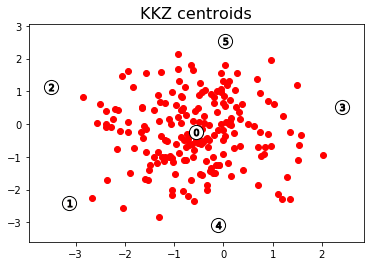

In [11]:
cent = kkz(data, k, metric)

## K-means algorithm

The K-Means methods attempts to maximize the explained variance of an ensemble. It tends to select members that are representative of high-density regions. Methodologicaly, k-means cannot produce an ordered sequence of solutions, where a 6-member clustering recomendation  being  different to the 5-member clustering ones.

#### Straight K-Means
1. Initial setting. Choose the number of clusters, $K$, and tentative centroids $c_1 c_2 \dots c_K$, frequently referred to as seeds. Initial cluster lists $S_k$ is empty.

2. Clusters update. Given $K$ centroids, determine clusters $S_{k0} (k = 1 \dots K )$ with the Minimum Distance rule.

3. Stop-condition. Check whether $S_0 = S$ . If yes, end with clustering $S = S_k , c = ( c_k )$. Otherwise, change $S$ for $S_0$.

4. Centroids update. Given clusters $S_k$, calculate within cluster means $c_k ( k = 1 \dots K)$ and go to Step 2.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.cluster import KMeans

def k_means(data, k):
    y = KMeans(n_clusters=k, random_state=seed).fit(data)

    # plotting
    plt.scatter(data[:, 0], data[:, 1], c='red')
    plt.title('K-means centroids', fontsize=16)

    # Labeling the clusters
    centers = y.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c='white', alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    plt.show()

    return centers

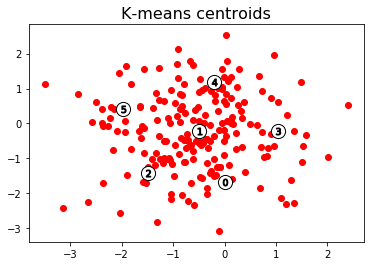

In [19]:
centers = k_means(data, k)

## Conclusions

By the results from two plots we can see explicitly the different results from both methods. While K-Means select centroids aligned with more dense regions in the space, KKZ selects points which are more distants and covers the variability from the space. If one aims to represent the variability more then the density of variability in some regions in the space, KKZ it is the best choice. 

Once our aim is to select a good subset which represents the variability from the initial set we want to compare how two methods catchs this variability while we increase k in each method. Lets plot the convex hull from two methods centroids

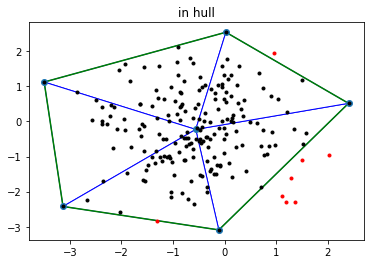

192

In [44]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0


def plot_in_hull(p, hull):
    """
    plot relative to `in_hull` for 2d data
    """
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection, LineCollection

    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    # plot triangulation
    poly = PolyCollection(hull.points[hull.vertices], facecolors='w', edgecolors='b')
    plt.clf()
    plt.title('in hull')
    plt.gca().add_collection(poly)
    plt.plot(hull.points[:,0], hull.points[:,1], 'o')


    # plot the convex hull
    edges = set()
    edge_points = []

    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(hull.points[ [i, j] ])

    for ia, ib in hull.convex_hull:
        add_edge(ia, ib)

    lines = LineCollection(edge_points, color='g')
    plt.gca().add_collection(lines)
    #plt.show()    

    # plot tested points `p` - black are inside hull, red outside
    inside = in_hull(p,hull)
    plt.plot(p[ inside,0],p[ inside,1],'.k')
    plt.plot(p[~inside,0],p[~inside,1],'.r')
    plt.show()    

    
    
plot_in_hull(data, cent)
np.count_nonzero(in_hull(data, cent))

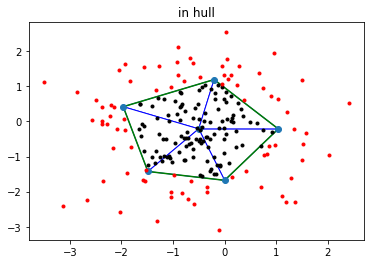

117

In [45]:
plot_in_hull(data, centers)
np.count_nonzero(in_hull(data, centers))

The K-Means method covers 117 points from same 200 points from data set while the KKZ method cover 192 points from 200 available. Same results were obtained in ~\cite{cannon}.